In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
import os
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

Set random seed for reproducibility

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

Load processed station data and combine

In [7]:
station1 = pd.read_parquet('../data/processed/station1_processed.parquet')
station2 = pd.read_parquet('../data/processed/station2_processed.parquet')

data = pd.concat([station1, station2], ignore_index=True).sort_values('model_output_valid_time')

Normalize and define features

In [8]:
data['lead_time'] = data['lead_time'] / 18.0
data['month'] = data['model_output_valid_time'].dt.month / 12
data['dayofyear'] = data['model_output_valid_time'].dt.dayofyear / 365
data['hour'] = data['model_output_valid_time'].dt.hour / 24

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data[['NWM_streamflow', 'USGS_streamflow']] = scaler.fit_transform(data[['NWM_streamflow', 'USGS_streamflow']])

FEATURES = ['NWM_streamflow', 'lead_time', 'month', 'dayofyear', 'hour']
TARGET = 'USGS_streamflow'

Split the data

In [9]:
train_data = data[data['model_output_valid_time'] < '2022-10-01']
test_data  = data[data['model_output_valid_time'] >= '2022-10-01']

X_train = train_data[FEATURES].values
y_train = train_data[TARGET].values
X_test = test_data[FEATURES].values
y_test = test_data[TARGET].values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

mask = (
    ~np.isnan(X_train).any(axis=(1, 2)) &
    ~np.isinf(X_train).any(axis=(1, 2)) &
    ~np.isnan(y_train) &
    ~np.isinf(y_train)
)
X_train = X_train[mask]
y_train = y_train[mask]

print("Samples:")
print(f"  Train: {X_train.shape[0]}")
print(f"  Test:  {X_test.shape[0]}")
print(f"  Total: {X_train.shape[0] + X_test.shape[0]}")
print()

print("Features per time step:", X_train.shape[2])
print("Time steps per input (sequence length):", X_train.shape[1])

Samples:
  Train: 1790711
  Test:  726652
  Total: 2517363

Features per time step: 5
Time steps per input (sequence length): 1


Define hyperparameters and build model

In [11]:
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
LSTM_UNITS = 64          
DROPOUT = 0.2 

def build_model(input_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.LSTM(LSTM_UNITS, dropout=DROPOUT))
    model.add(layers.Dense(1))

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse')
    return model

model = build_model((X_train.shape[1], X_train.shape[2]))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Create directory to save model

In [12]:
model_dir = Path('./saved_models')
model_dir.mkdir(exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_dir / 'streamflow_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True
    )
]

Train the model

In [13]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0071 - val_loss: 0.0015 - learning_rate: 5.0000e-04
Epoch 2/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0066 - val_loss: 7.4416e-04 - learning_rate: 5.0000e-04
Epoch 3/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0065 - val_loss: 6.8942e-04 - learning_rate: 5.0000e-04
Epoch 4/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0064 - val_loss: 5.2831e-04 - learning_rate: 5.0000e-04
Epoch 5/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.0063 - val_loss: 4.9603e-04 - learning_rate: 5.0000e-04
Epoch 6/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0063 - val_loss: 4.7796e-04 - learning_rate: 5.0000e-04
Epoch 7/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0062 - val_loss: 4.9792e-04 - learning_rate: 5.0000e-04
Epoch 8/100
6296/6296 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0061 - val_loss: 4.5571e-04 - learning_rate: 5.0000e-04
Epoch 9/100
6296/6296 ━━━━━━

Visualize the training loss

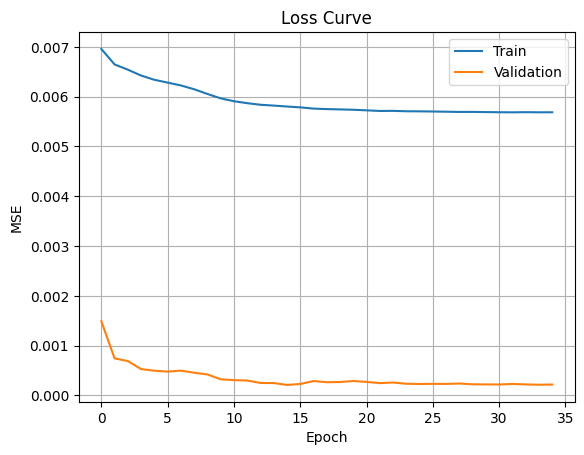

In [14]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

Load best model and evaluate

In [30]:
model = keras.models.load_model(model_dir / 'streamflow_model.keras')

predicted = model.predict(X_test).flatten()

predicted_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, predicted]).T
)[:, 1]

usgs_true_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, y_test]).T
)[:, 1]

nwm_denorm = scaler.inverse_transform(
    np.vstack([test_data['NWM_streamflow'].values, test_data['NWM_streamflow'].values]).T
)[:, 1]

22708/22708 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step


Metrics and visualization

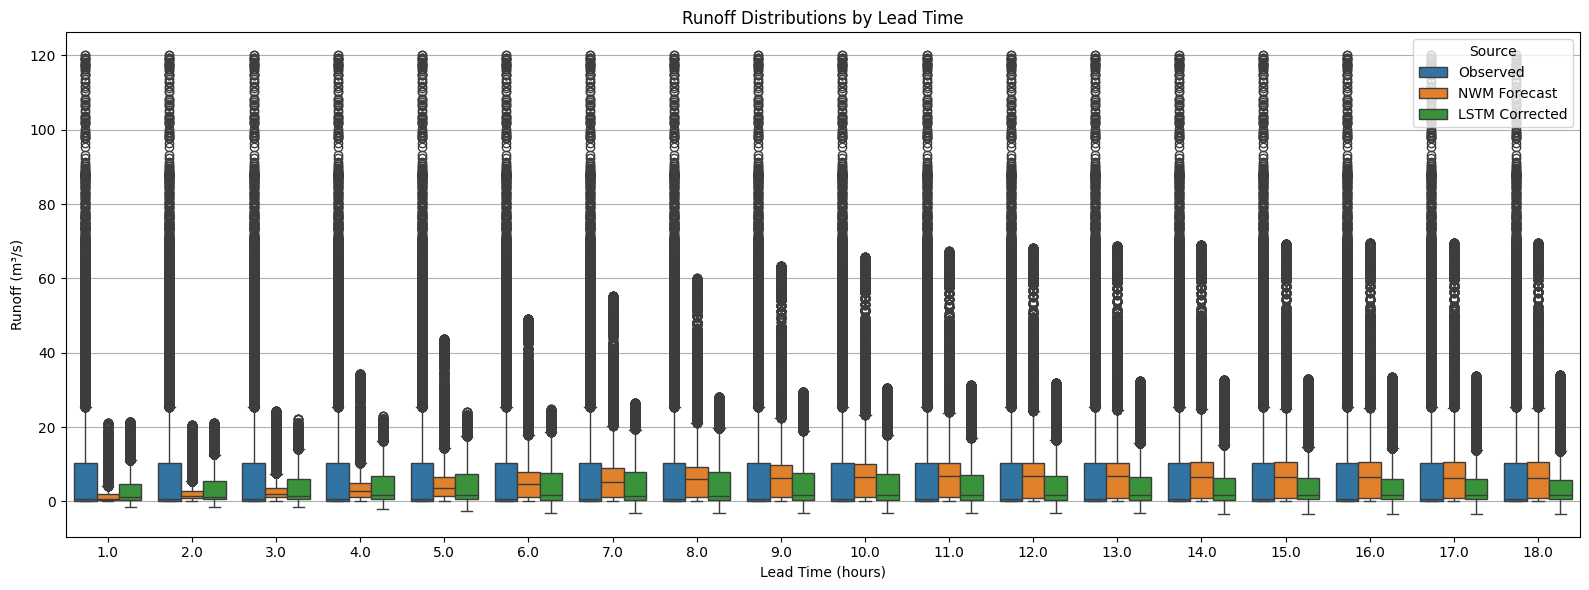

In [31]:
test_data['predicted'] = predicted_denorm
test_data['USGS_true'] = usgs_true_denorm
test_data['NWM_true'] = nwm_denorm

runoff_melted = pd.melt(
    test_data,
    id_vars=['lead_time_hr'],
    value_vars=['USGS_true', 'NWM_true', 'predicted'],
    var_name='Source',
    value_name='Runoff'
)

source_map = {
    'USGS_true': 'Observed',
    'NWM_true': 'NWM Forecast',
    'predicted': 'LSTM Corrected'
}
runoff_melted['Source'] = runoff_melted['Source'].map(source_map)

plt.figure(figsize=(16, 6))
sns.boxplot(x='lead_time_hr', y='Runoff', hue='Source', data=runoff_melted)
plt.xlabel('Lead Time (hours)')
plt.ylabel('Runoff (m³/s)')
plt.title('Runoff Distributions by Lead Time')
plt.legend(title='Source')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Box Plot Function

In [35]:
from scipy.stats import pearsonr

def nse(observed, simulated):
    observed = np.asarray(observed)
    simulated = np.asarray(simulated)
    return 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

metrics_records = []
chunk_size = 6

for lt in sorted(test_data['lead_time_hr'].unique()):
    subset = test_data[test_data['lead_time_hr'] == lt]
    obs = subset['USGS_true'].values
    nwm = subset['NWM_true'].values
    lstm = subset['predicted'].values
    
    for o, n, l in zip(obs, nwm, lstm):
        if o == 0: continue
        metrics_records.append({
            'Lead Time': int(lt),
            'Source': 'NWM',
            'RMSE': np.sqrt((o - n) ** 2),
            'PBIAS': 100 * (n - o) / o,
        })
        metrics_records.append({
            'Lead Time': int(lt),
            'Source': 'LSTM',
            'RMSE': np.sqrt((o - l) ** 2),
            'PBIAS': 100 * (l - o) / o,
        })
        
    chunk_count = 0
    for i in range(0, len(obs) - chunk_size + 1, chunk_size):
        obs_chunk = obs[i:i + chunk_size]
        nwm_chunk = nwm[i:i + chunk_size]
        lstm_chunk = lstm[i:i + chunk_size]

        if (
            np.std(obs_chunk) == 0 or np.isnan(obs_chunk).any()
            or np.isnan(nwm_chunk).any() or np.isnan(lstm_chunk).any()
        ):
            continue

        try:
            cc_nwm = pearsonr(obs_chunk, nwm_chunk)[0]
            cc_lstm = pearsonr(obs_chunk, lstm_chunk)[0]
        except:
            continue

        metrics_records.append({
            'Lead Time': int(lt),
            'Source': 'NWM',
            'CC': pearsonr(obs_chunk, nwm_chunk)[0],
            'NSE': nse(obs_chunk, nwm_chunk),
        })
        metrics_records.append({
            'Lead Time': int(lt),
            'Source': 'LSTM',
            'CC': pearsonr(obs_chunk, lstm_chunk)[0],
            'NSE': nse(obs_chunk, lstm_chunk),
        })
        chunk_count += 1

print(f'Lead Time {lt}hr — valid NSE/CC chunks: {chunk_count}')   
    
metrics_long = pd.DataFrame(metrics_records)

C:\Users\johnm\AppData\Local\Temp\ipykernel_14852\3337757252.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cc_nwm = pearsonr(obs_chunk, nwm_chunk)[0]
C:\Users\johnm\AppData\Local\Temp\ipykernel_14852\3337757252.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cc_lstm = pearsonr(obs_chunk, lstm_chunk)[0]
C:\Users\johnm\AppData\Local\Temp\ipykernel_14852\3337757252.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'CC': pearsonr(obs_chunk, nwm_chunk)[0],
C:\Users\johnm\AppData\Local\Temp\ipykernel_14852\3337757252.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'CC': pearsonr(obs_chunk, lstm_chunk)[0],


Lead Time 18.0hr — valid NSE/CC chunks: 6599


Box Plots of Metrics

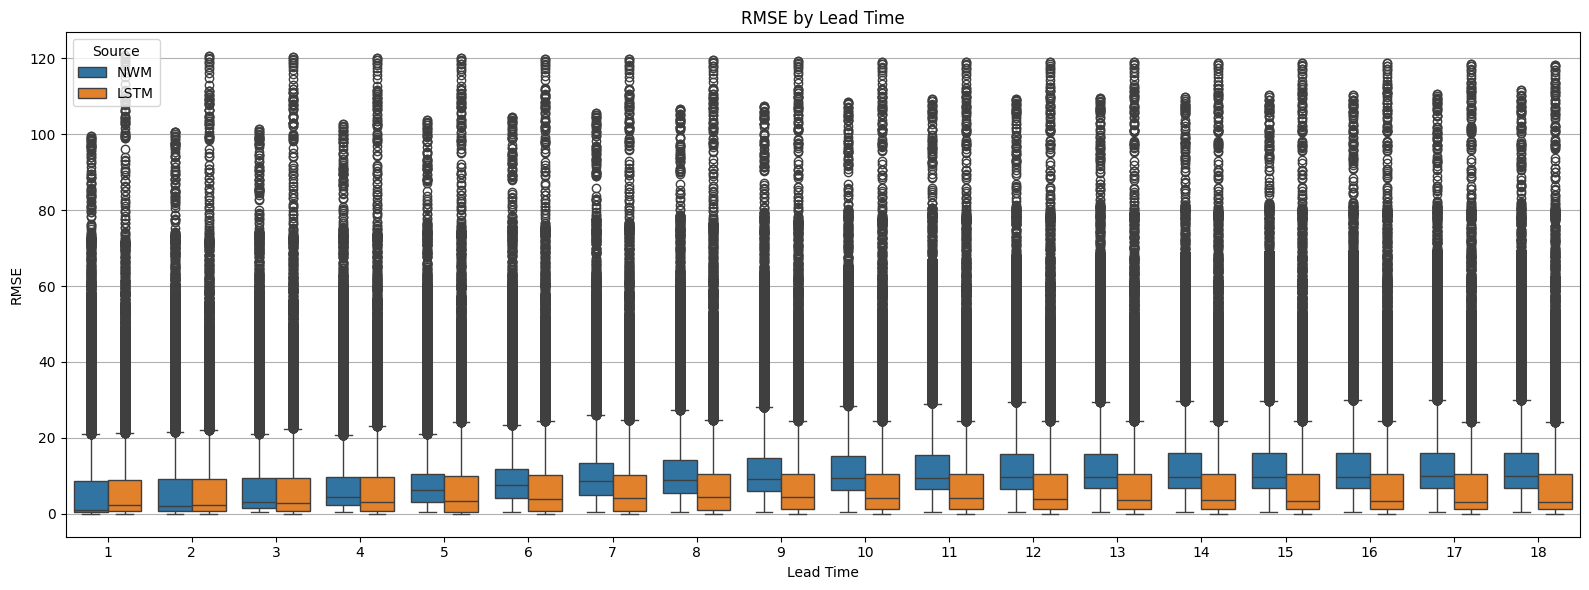

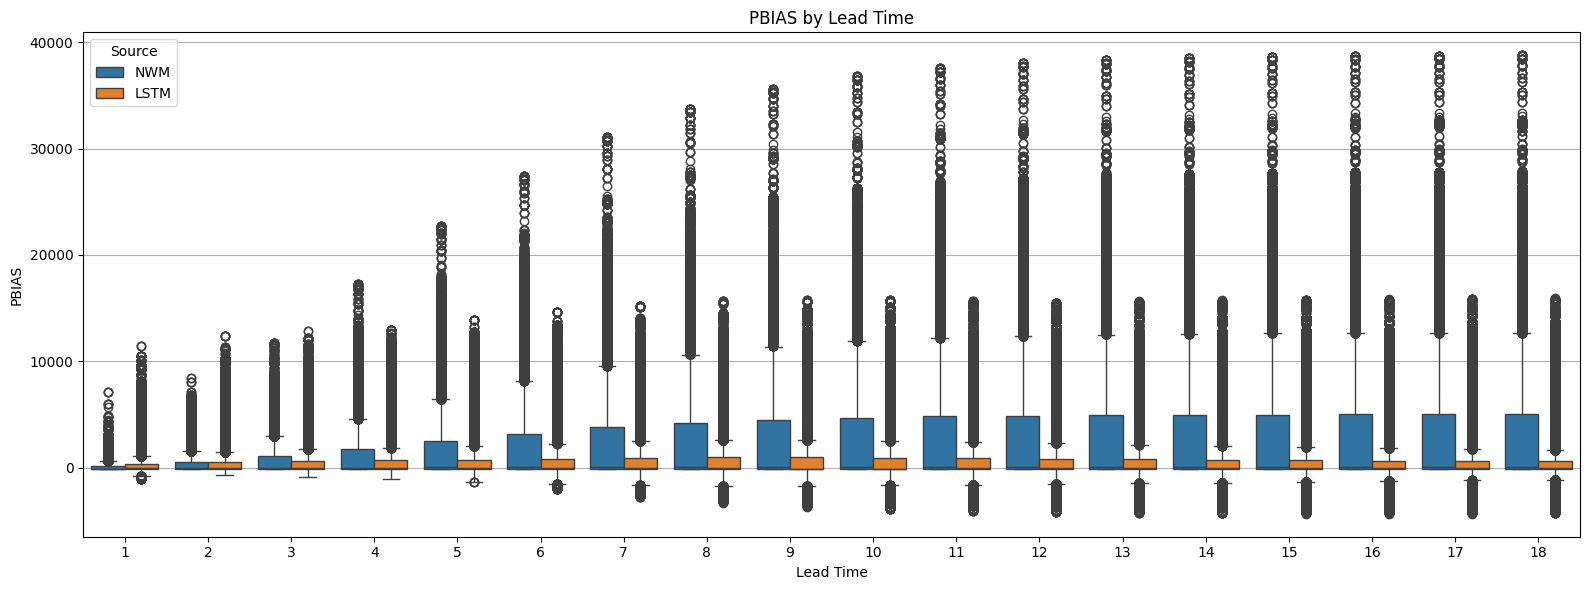

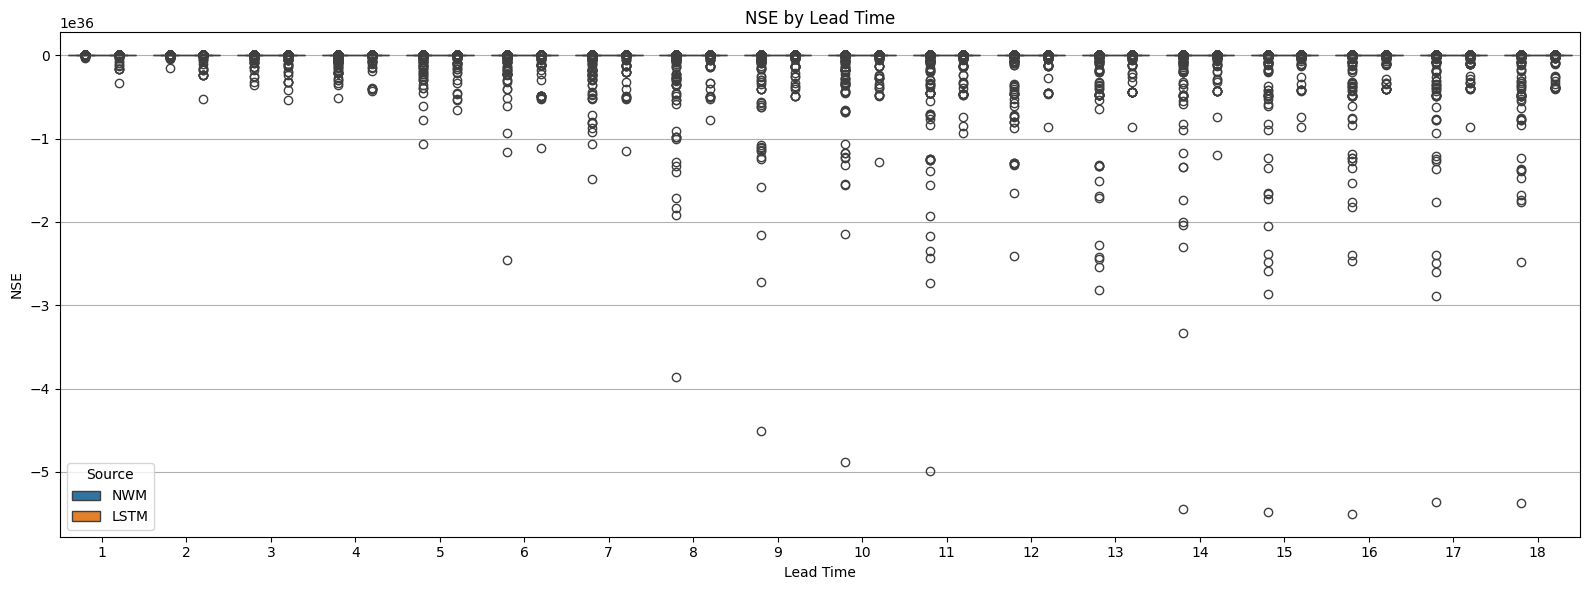

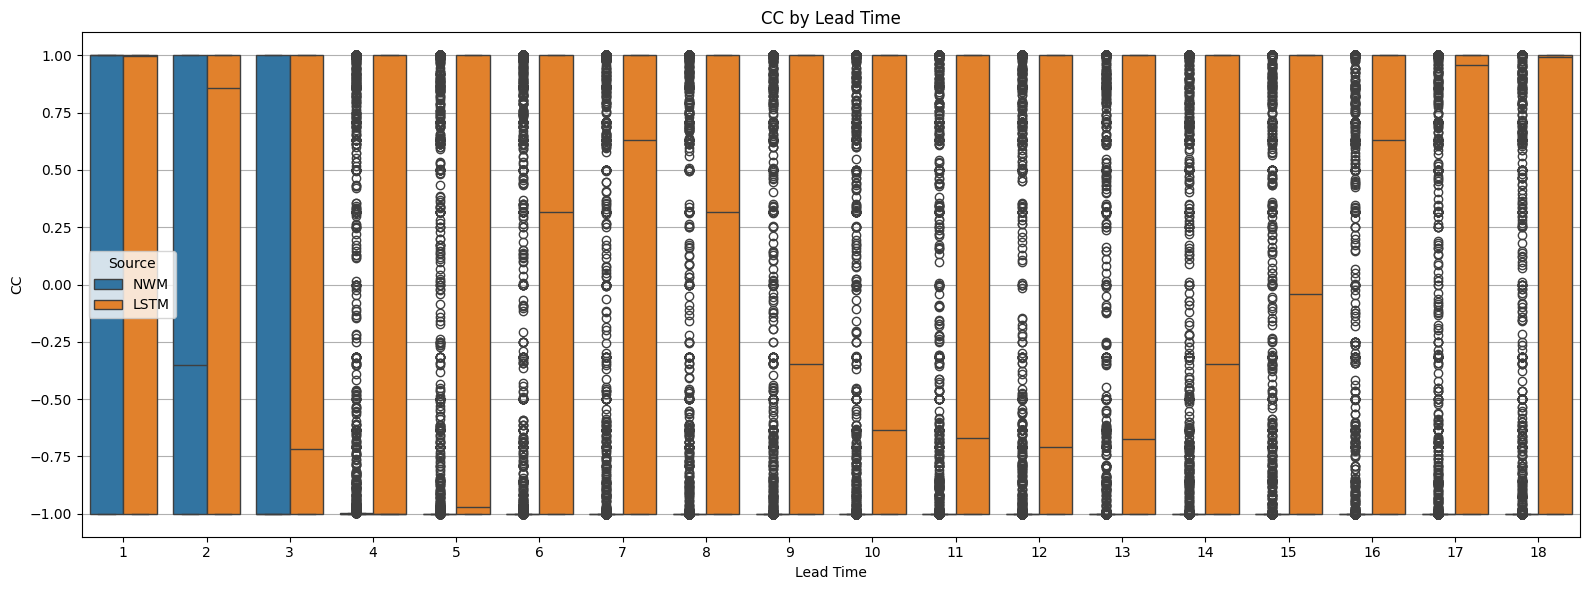

In [36]:
def plot_metric_box_from_long(df, metric):
    plt.figure(figsize=(16, 6))
    sns.boxplot(x='Lead Time', y=metric, hue='Source', data=df[df[metric].notnull()])
    plt.title(f'{metric} by Lead Time')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

for m in ['RMSE', 'PBIAS', 'NSE', 'CC']:
    plot_metric_box_from_long(metrics_long, m)